# Til eksamen - numeriske beregninger

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import optimize
import tensorflow as tf

## ODE - IKKE RELEVANT

#### FTBS

In [56]:
#non-linear, conservative
def FTBS(u):
    
    u_new = np.zeros_like(u[1:-1])
    
    Fj = flux(u[1:-1])
    Fj_minus = flux(u[:-2])
    u_new[:] = u[1:-1] - (dt/dx)*(Fj - Fj_minus)
    
    return u_new

#### FTCS

In [57]:
def solveNextTimestepFTCS(Uold, D, U_b=1, U_t=0): #siste to e boundary conditions og initial conditions
    Unew = np.zeros_like(Uold)                    #D = numerical diffusion number
    
    Uold_plus = Uold[2:]
    Uold_minus = Uold[:-2]
    Uold_mid = Uold[1:-1]
    
    Unew[1:-1] = D*(Uold_plus + Uold_minus) + (1 - 2*D)*Uold_mid
    Unew[0] = U_b
    Unew[-1] = U_t
    
    return Unew

#### MacCormack

In [58]:
def macCormack(u):
    up = np.zeros_like(u)
    up[:-1] = u[:-1] - c*(u[1:]-u[:-1])
    u[1:] = .5*(u[1:]+up[1:] -  c*(up[1:]-up[:-1]))
    return u[1:-1] 


# Constants and parameters
a = 1.0 # wave speed
tmin, tmax = 0.0, 1.0 # start and stop time of simulation
xmin, xmax = 0.0, 2.0 # start and end of spatial domain
Nx = 80 # number of spatial points
c = 0.9 # courant number, need c<=1 for stability

## PDE - IKKE RELEVANT

#### A-matrise

In [59]:
#centered finite difference - with ghost nodes
def matrix(N):                #matrise N**2 x N**2
    d_0 = -4*np.ones(N**2)    #diagonalen; -4
    
    d_1o = np.ones(N**2-1)    #første over diagonalen; 1
    d_1o[N-1::N]=0            #                        hver N-te verdi er 0
    
    d_No = 2*np.ones(N**2-N)  #N over diagonalen; 2
    d_No[N::]=1               #                   fra N+1-te verdi er alle 1
    
    d_1u = np.ones(N**2-1)    #første under diagonalen; 1
    d_1u[N-2::N]=2            #                         hver N-1-te 2
    d_1u[N-1::N]=0            #                         hver N-te er 0
    
    d_Nu = np.ones(N**2-N)    #N under diagonalen; 1
    
    return scipy.sparse.diags([d_Nu,d_1u,d_0,d_1o,d_No],[-N,-1,0,1,N]).toarray()

print(matrix(3))

[[-4.  1.  0.  2.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  2.  0.  0.  0.  0.]
 [ 0.  2. -4.  0.  0.  2.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  2. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  2. -4.]]


#### b-matrise

In [60]:
#Defining the 1xN b-matrix in accordance to the boundaries
def b_matrix(N):
    b = np.zeros(N**2)
    b[::N] = -50             #Hver N-te node skal være -50, begynner på første
    b[-N:] = -100            #De N siste nodene skal være -100 grader 
    b[-N] = -150             #N-te siste node skal være -150 grader
    return b

#matrisen viser hver node fra bunnen til venstre og radvis oppover
print(b_matrix(3))

[ -50.    0.    0.  -50.    0.    0. -150. -100. -100.]


## OPT

#### Curve fitting

1. Definer funksjon
    - Alle gitte verdier som inputs
    
2. Definer x-akse og y
    - y er da funksjonen med gitte verdier
    
3. Plot

In [110]:
popt, pcov = scipy.optimize.curve_fit(f, xdata, ydata, p0, bounds)

plt.plot(x, y, label='data set')                     #plott av datasett
plt.plot(x, f(x, *popt), label='curve_fit result')   #plott av curve fitting-modellen

   - f: model function, funksjonen definert
   - xdata: x-aksen
   - ydata: avhengig data, y som er definert
   - p0: initial guess
   - bounds: nedre og øvre grense for parametre
    
   - popt vil returnere verdiene for de ulike parametrene for curve fittingen

#### Minimization

1. Definer nødvendige funksjoner
    - funksjoner gitt
    - funksjonen som skal minimeres
    - gjerne bare en input x og definer etterpå liste med hver input som x; ['sigma', 'rho', osv] = x
      alltid samme rekkefølge på dem så initial guess kan settes som en liste med dem i
2. Minimer

In [ ]:
res = scipy.optimize.minimize(fun, x0, args=arguments, method=None, bounds=bounds, constraints=cons, options=options)

   - fun: funksjonen vi skal minimere
        - må returnere en skalar
        - dersom funksjonen tar inn flere variabler, sett de felles som input: fun(x, data)
             - Definer data som liste med variablene: data = [y, z, m, n]
             - Definer arguments som tuppel av listen med variablene: arguments = (data,)
   - x0: initial guess
        - må være innenfor definert x-felt (i bounds)
        - så nære minimum som mulig
   - options: gir ekstra parametre
        - options = {'disp':True, 'maxiter':1000}
            - disp skrur av (False) eller på (True) output av optimization
            - maxiter: maximum antall iterasjoner
   - bounds: tuppel  med grenser for variablene
        - bounds = ( )
          bounds.append((min_x1, max_x1))
          bounds.append((min_x2, max_x2)) osv.
        - Dersom ingen grenser: bounds.append((-np.inf, np.inf))
   - constraints: dictionaries som viser til begrensninger
        - constraints = []
          constraints.append({'type':' ', 'fun': })
            - 'type':'ineq' eller 'eq'
            - for ineq: 
                 - F(x) > F0 --> {'type':'ineq', 'fun': lambda x: F(x)-F0}
                 - F(x) < F0 --> {'type':'ineq', 'fun': lambda x: F0-F(x)}  
   - method: hvilken algoritme som skal benyttes
        - tre som ikke krever bounds og constraints:
            - 'Nelder-Mead'
            - 'BFGS'
            - 'CG'
        - 'SLSQP' Passer ofte
        - 'COBYLA'
        - 'trust-constr'

3. Hent info
    - res.x: optimale resultater/verdier
    - res.nit: antall iterasjoner som trengs for å fullføre optimaliseringen
    - res.nfev: antall funksjonsevalueringer

In [ ]:
x0 = []
        
x0.append([100, 0.1, 1, 50, 0])     #nedre grenser
x0.append([200, 0.3, 2, 75, 200])   #midt mellom
x0.append([300, 0.5, 3, 100, 400])  #øvre grenser

#SETT DEM I SAMME REKKEFØLGE SOM LISTEN E DEFINERT I FUNKSJONAN

In [ ]:
x = []
for i in x0: 
    res = scipy.optimize.minimize(M, x0=i, method='SLSQP', bounds=bounds, constraints=cons, options={'disp': False, 'maxiter':1000})
    x.append(res.x)

#Får en liste med beste resultatene for hvert sett med verdier
#Kan finne optimale verdier med å putte disse x-verdiene inn i funksjonene som skal minimeres

#### Global optimization

1. Definer nødvendige funksjoner
    - gitte funksjoner
    - funksjon å minimere
2. Optimer ved bruk av basinhopping

In [ ]:
res = scipy.optimize.basinhopping(fun, x0, niter=100, mininmizer_kwargs=None)

   - fun: funksjonen vi vil minimere
        - må returnere skalar
             - eventuelle ekstra variabelinputs må inn i minimizer_kwargs
   - x0: initial guess
        - må være innenfor bounds/constraints
   - niter: antall iterasjoenr
        - standard: 100
   - minimizer_kwargs: nøkkelinfo til lokal minimizer
        - føres som en dictionary:
          minimizer_kwargs = {'method':'SLSQP', 'args':arguments, 'bounds':bounds, 'constraints':cons}
             - method: algoritme
             - args: ekstra variabelinputs til funksjon
             - bounds og constraints: grenser og betingelser

3. Hent info
    - res.x: optimale resultater/verdier
    - res.nit: antall iterasjoner som trengs for å fullføre optimaliseringen
    - res.nfev: antall funksjonsevalueringer

#### Differential evolution

- stokastisk; krever ikke initial guess

In [ ]:
res = scipy.optimize.differential_evolution(fun, bounds=bounds, args=arguments, workers=1, constraints=cons)

   - fun: funksjonen vi vil minimere
   - bounds: grenser for variabler/parametre
   - args: ekstra variabler til funksjonen
   - constraints: begrensninger for funksjon
   - workers: antall CPU-er for parallell prosessering

Hent info
   - res.x: optimale resultater/verdier
   - res.nit: antall iterasjoner som trengs for å fullføre optimaliseringen
   - res.nfev: antall funksjonsevalueringer

## ML

HENTE DATA

In [61]:
data = np.loadtxt('Data_Example_1_small.txt')   #txt-fil
data2 = pd.read_csv('training(1).csv')          #excel-fil

#Dersom tall splittes med komma:
data3 = np.loadtxt('Data_Example_5.txt',delimiter=',')

HENTE INPUT OGOUTPUT FRA DATA

In [88]:
input_data, output_data  = data[:,0:3], data[:,-1]
#input e her tre første kolonner, og output siste kolonne

#data[RADx:RADy, KOLONNEx:KOLONNEy]   hent ut fra kolonne/rad x til y

LAGE FIGUR AV DATA
   - fra example 1, har dem input som x og output som y. En for hver kolonne

No handles with labels found to put in legend.
No handles with labels found to put in legend.


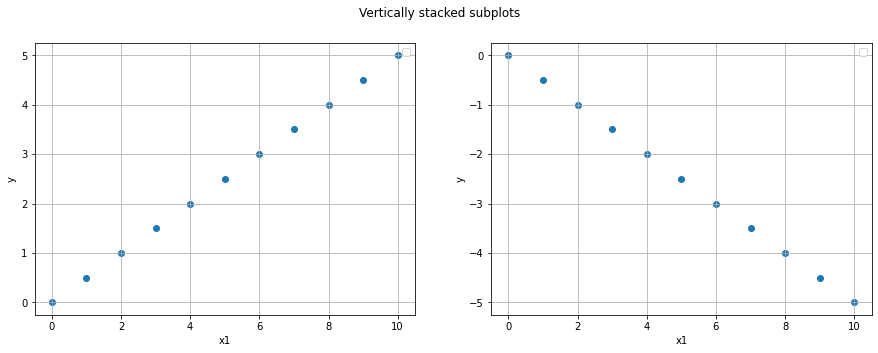

In [89]:
x=np.linspace(0,10,11)
y=np.linspace(0,5,11)
#Flere figurer
plt.rcParams["figure.figsize"] = (15, 5)     #Størrelse figurer

fig, (ax1, ax2) = plt.subplots(1,2)          #antall subplots og oppsett. (#rader,#kolonner)
fig.suptitle('Vertically stacked subplots')  #Felles tittel

ax1.scatter(x, y)                            #Hva som skal plottes i hver, scatter gir punkter istedenfor plot som gir linjer
ax1.set_xlabel('x1')                         #tittel på hver akse
ax1.set_ylabel('y')
ax1.legend()
ax1.grid()

ax2.scatter(x, -y)
ax2.set_xlabel('x1')
ax2.set_ylabel('y')
ax2.legend()
ax2.grid()

LAGE ARTIFICIAL NEURAL NETWORK - ANN

In [95]:
#ulike metoder:
#1
inputs = tf.keras.Input(shape=(3,))                        #antall inputs for ANN
x = tf.keras.layers.Dense(1000, activation='relu')(inputs) #This add a layer of here 1000 neurons with the relu activation function
outputs = tf.keras.layers.Dense(1, activation='linear')(x) #The output layer with one ouput and the linear activation function
model = tf.keras.Model(inputs=inputs, outputs=outputs)     #We setup the inputs and outputs of the ANN

#2
model = tf.keras.models.Sequential()                                         # We define here a sequential ANN
model.add(tf.keras.layers.Dense(units=1000, activation='relu', input_dim=3)) # We define the input layer and neurons
model.add(tf.keras.layers.Dense(units=1000, activation='linear'))            # add ghost layer with given number of neurons
model.add(tf.keras.layers.Dense(units=1, activation='linear'))               # We define the output layer and neurons 
#                                                                              as number of outputs

#kompilerer
model.compile(loss='mse', optimizer='adam')                #We compile the ANN model specifying the loss metric and optimizer

TRENE/DEFINERE ANN

In [96]:
#sett antall epochs
epochs = 10

history = model.fit(input_data, output_data, epochs=epochs,verbose=0)

#Kan printe minimum og maksimum error som er gjort under treningen
print('Minimum error : {}, Maximum error: {}'.format(np.min(history.history['loss']),np.max(history.history['loss'])))

Minimum error : 3.717324489116436e-06, Maximum error: 0.006987313274294138


In [97]:
#Kan printe antallet av ulike parametre
for layer in model.layers:
    nrow = np.shape(layer.get_weights())[0]
    if nrow != 0: 
        print('Number of weights = ',np.shape(layer.get_weights()[0]))
        print('Number of bias = ',np.shape(layer.get_weights()[1]))

Number of weights =  (3, 1000)
Number of bias =  (1000,)
Number of weights =  (1000, 1)
Number of bias =  (1,)


BRUKE ANN TIL PREDICTION

In [98]:
prediction = model.predict(input_data)

PLOTTE ANN

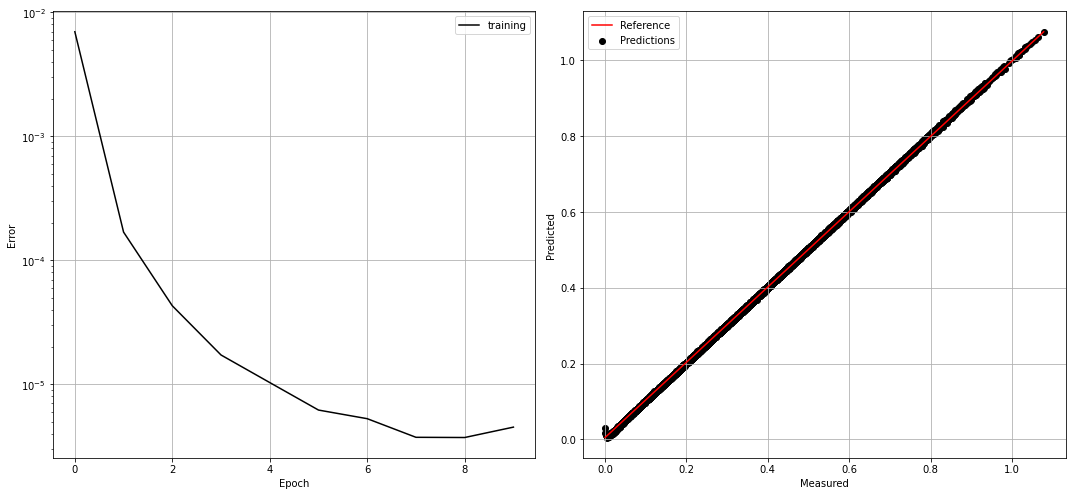

In [99]:
plt.rcParams["figure.figsize"] = (15, 7)                   #Størrelse

#Plotte error for training
fig,(ax1,ax2) = plt.subplots(1,2)                          #antall og oppsett
ax1.semilogy(history.history['loss'],'k',label='training') #Semilog y-aksen; lager logaritmisk skala for aksen, får se
ax1.set_xlabel('Epoch')                                    #                 der det faktisk er forandringer
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid()

# Plot output vs. predictions from ANN 
ax2.scatter(output_data,prediction,c='k',label='Predictions')
ax2.plot([np.min(output_data),np.max(output_data)],[np.min(prediction),np.max(prediction)],'r',label='Reference')
ax2.set_xlabel('Measured')
ax2.set_ylabel('Predicted')
ax2.legend()
ax2.grid()

fig.tight_layout()   #Gjør at den passer

LAGRE DATA I ANN

In [100]:
#hvis man skal bruke den i anna notebook
model.save('model_small.pb')

INFO:tensorflow:Assets written to: model_small.pb\assets


HENTE INN ANN FRA ANNEN NOTEBOOK

In [102]:
model = tf.keras.models.load_model('model_small.pb')  #Navnet man har lagret den andre dataen som

#### PLOTTING HVIS MAN HAR FLERE ULIKE DATASETT

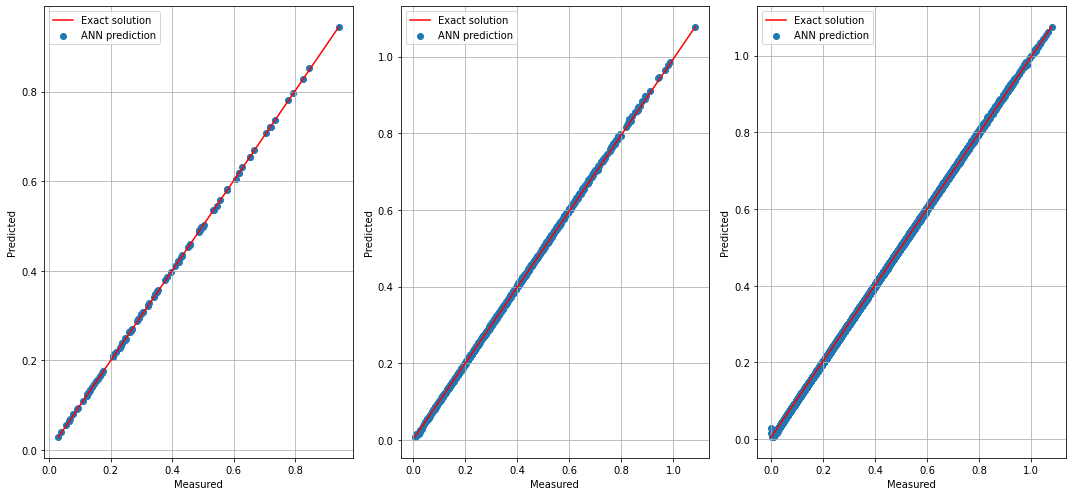

In [101]:
data_small = np.loadtxt('data_small.txt')
data_medium = np.loadtxt('data_medium.txt')
data_large = np.loadtxt('data_large.txt')

datasets = [data_small, data_medium, data_large]     #tre ulike dataseett

fig,axs = plt.subplots(1,len(datasets))              #én rad med antall tabella som vi har antall datasett

plt.rcParams["figure.figsize"] = (10, 5) 

for i,data in enumerate(datasets):                    
    input_data,output_data  = data[:,0:3], data[:,3]
    # Predict output using the ANN
    prediction = model.predict(input_data)
    # Plot the predictions
    axs[i].scatter(output_data,prediction,label='ANN prediction')
    # Plot the measurements
    axs[i].plot([np.min(output_data),np.max(output_data)],[np.min(prediction),np.max(prediction)],'r',label='Exact solution')
    # 
    axs[i].set_xlabel('Measured')
    axs[i].set_ylabel('Predicted')
    axs[i].legend()
    axs[i].grid()
    
fig.tight_layout()

#### FORBEDRE EN ANN

In [103]:
#1: Øk antall epochs

#2: normaliser og prøv med nye verdier
output_data_new = (output_data - np.min(output_data)) / (np.max(output_data) - np.min(output_data))

### Skalering med sklearn

In [104]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

MAX/MIN-SKALER

In [106]:
#Min/Max scaler:
scaler = preprocessing.MinMaxScaler().fit(data)
scaled_data = scaler.transform(data)
#Splitter deretter scaled_data inn i input- og output-kolonner som vanlig

STANDARD SKALERING

In [ ]:
scaler_x = preprocessing.StandardScaler().fit(input_data)
x_scaled = scaler_x.transform(input_data)

scaler_y = preprocessing.StandardScaler().fit(output_data)
y_scaled = scaler_y.transform(output_data)

#Her er det da delt inn på forhånd, men trur max/min e bedre siden det e brukt i eksempel

#### Splitte inn i training og testing

In [108]:
#Definer training og validation
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_scaled,test_size = 0.2, train_size = 0.8, random_state = 1)

#Test_size og train_size vider til en 80/20-splitt

#For historyen til ANN må det legges til for validation:
history = model.fit(x_scaled, y_scaled, epochs=epochs, validation_data=(x_val,y_val), verbose=0)